In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt


# Load GVI statistics
gvi_df = pd.read_csv("output/lsoa_15min_green_gvi_with_cv_weighted2.csv")

# Load raw IMD data
imd_df = pd.read_csv("data/IMD/id_2019_london.csv")

# Load raw IMD data
imd_df.columns = (
    imd_df.columns.astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
    .str.strip("_")
)

# Rename fields to a consistent format
imd_df = imd_df.rename(columns={
    "lsoa_code_2011": "lsoa_code",
    "index_of_multiple_deprivation_imd_score": "imd_score",
    "index_of_multiple_deprivation_imd_rank_where_1_is_most_deprived": "imd_rank",
    "index_of_multiple_deprivation_imd_decile_where_1_is_most_deprived_10_of_lsoas": "imd_decile",
    "income_score_rate": "income_score",
    "employment_score_rate": "employment_score",
    "education_skills_and_training_score": "edu_score",
    "health_deprivation_and_disability_score": "health_score",
    "crime_score": "crime_score",
    "barriers_to_housing_and_services_score": "barrier_score",
    "living_environment_score": "env_score"
})

# Select required fields
imd_df = imd_df[[
    "lsoa_code",
    "imd_score",
    "imd_rank",
    "imd_decile",
    "income_score",
    "employment_score",
    "edu_score",
    "health_score",
    "crime_score",
    "barrier_score",
    "env_score"
]]

# Merge GVI and IMD datasets
merged_df = pd.merge(
    gvi_df,
    imd_df,
    how="left",
    left_on="LSOA11CD",  
    right_on="lsoa_code"
)

# Reorder columns: include 4 GVI fields + IMD
merged_df = merged_df[[
    "lsoa_code",
    "green_mean_15min_simple",
    "green_mean_15min_weighted",
    "green_std_15min",
    "green_cv_15min",
    "num_samples",
    "imd_score",
    "imd_rank",
    "imd_decile",
    "income_score",
    "employment_score",
    "edu_score",
    "health_score",
    "crime_score",
    "barrier_score",
    "env_score"
]]

# Save merged results
merged_df.to_csv("output/gvi_cv_imd_merged_weighted.csv", index=False)
print("saved：output/gvi_cv_imd_merged_weighted.csv")


saved：output/gvi_cv_imd_merged_weighted.csv


In [2]:
# Display first 5 rows
print(merged_df.head())

   lsoa_code  green_mean_15min_simple  green_mean_15min_weighted  \
0  E01000001                 0.071976                   0.071298   
1  E01000002                 0.066235                   0.064601   
2  E01000003                 0.096566                   0.093937   
3  E01000005                 0.070562                   0.071846   
4  E01000842                 0.275085                   0.279197   

   green_std_15min  green_cv_15min  num_samples  imd_score  imd_rank  \
0         0.097823        1.372021        21120      6.208     29199   
1         0.093450        1.446566        22060      5.143     30379   
2         0.108595        1.156038        19249     19.402     14915   
3         0.091269        1.270340        21823     28.652      8678   
4         0.124414        0.445614         7490      8.523     26391   

   imd_decile  income_score  employment_score  edu_score  health_score  \
0           9         0.007             0.010      0.024        -1.654   
1         

In [3]:
# Load LSOA boundaries and reproject to British National Grid
import geopandas as gpd
lsoa = gpd.read_file("data/ESRI/LSOA_2011_London_gen_MHW.shp").to_crs(epsg=27700)
inner_boroughs = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]

lsoa = lsoa[lsoa["LAD11NM"].isin(inner_boroughs)].copy()

## Step 1: Green View Index Differences across Socioeconomic Strata

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# Step 1.1 Add IMD quintiles (relative stratification within London)

# Load merged dataset
df = pd.read_csv("output/gvi_cv_imd_merged_weighted.csv")

# Create IMD quintiles (relative stratification for Inner London)
df["imd_quintile"] = pd.qcut(df["imd_score"], q=5, labels=[1, 2, 3, 4, 5])

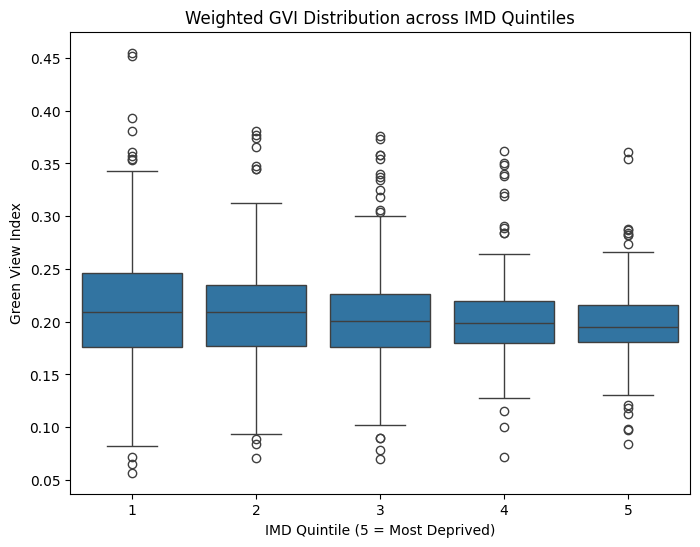

Kruskal-Wallis H = 22.435, p = 0.0002

Dunn’s post hoc result (p-values):
          1         2         3         4         5
1  1.000000  1.000000  0.047763  0.022843  0.000493
2  1.000000  1.000000  0.486769  0.278039  0.013413
3  0.047763  0.486769  1.000000  1.000000  1.000000
4  0.022843  0.278039  1.000000  1.000000  1.000000
5  0.000493  0.013413  1.000000  1.000000  1.000000


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/3591090681.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group["green_mean_15min_weighted"].values for _, group in df.groupby("imd_quintile")]


In [5]:
# Ensure output directory exists
output_dir = "output/4/4.1.1"
os.makedirs(output_dir, exist_ok=True)

# Step 1.2 Boxplots + Kruskal–Wallis test + Dunn’s test

# Boxplot: visualize GVI distribution across socioeconomic groups
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="imd_quintile", y="green_mean_15min_weighted")
plt.xlabel("IMD Quintile (5 = Most Deprived)")
plt.ylabel("Green View Index")
plt.title("Weighted GVI Distribution across IMD Quintiles")
# Save figure
plt.savefig(os.path.join(output_dir, "gvi_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()

# Kruskal–Wallis test (non-parametric, multi-group differences)
groups = [group["green_mean_15min_weighted"].values for _, group in df.groupby("imd_quintile")]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

# If significant (p < 0.05), perform Dunn’s post hoc test
if p < 0.05:
    dunn_result = sp.posthoc_dunn(df, val_col="green_mean_15min_weighted", group_col="imd_quintile", p_adjust="bonferroni")
    print("\nDunn’s post hoc result (p-values):")
    print(dunn_result)

In [6]:
# Step 1.3 Calculate mean and standard deviation of GVI for each quintile
stats_gvi_per_quintile = (
    df.groupby("imd_quintile")["green_mean_15min_weighted"]
    .agg(mean_gvi="mean", std_gvi="std", median_gvi="median")
    .reset_index()
)

print("\nMean and standard deviation of GVI for each IMD quintile:")
print(stats_gvi_per_quintile)

stats_gvi_per_quintile.to_csv(os.path.join(output_dir, "gvi_stats.csv"), index=False)


Mean and standard deviation of GVI for each IMD quintile:
  imd_quintile  mean_gvi   std_gvi  median_gvi
0            1  0.213864  0.056376    0.209375
1            2  0.207524  0.048113    0.209109
2            3  0.203013  0.044717    0.200659
3            4  0.201241  0.037349    0.198805
4            5  0.198431  0.033098    0.194533


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/2092093084.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("imd_quintile")["green_mean_15min_weighted"]


In [7]:
# Step 1.2.4 Calculate mean, standard deviation, and median of GVI CV for each quintile

stats_cv_per_quintile = (
    df.groupby("imd_quintile")["green_cv_15min"]
    .agg(mean_cv="mean", std_cv="std", median_cv="median")
    .reset_index()
)

print("\nMean, standard deviation, and median of GVI CV for each IMD quintile:")
print(stats_cv_per_quintile)

stats_cv_per_quintile.to_csv(os.path.join(output_dir, "gvi_cv_stats.csv"), index=False)


Mean, standard deviation, and median of GVI CV for each IMD quintile:
  imd_quintile   mean_cv    std_cv  median_cv
0            1  0.651377  0.162423   0.629004
1            2  0.642197  0.141372   0.615273
2            3  0.640456  0.127789   0.626378
3            4  0.629665  0.111510   0.606065
4            5  0.627755  0.100214   0.610828


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/2535125540.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("imd_quintile")["green_cv_15min"]


In [8]:
df['imd_quintile'].value_counts().sort_index()
df.groupby("imd_quintile")["imd_score"].mean()

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1386751347.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("imd_quintile")["imd_score"].mean()


imd_quintile
1    10.251750
2    17.748294
3    24.209585
4    30.668550
5    39.079690
Name: imd_score, dtype: float64

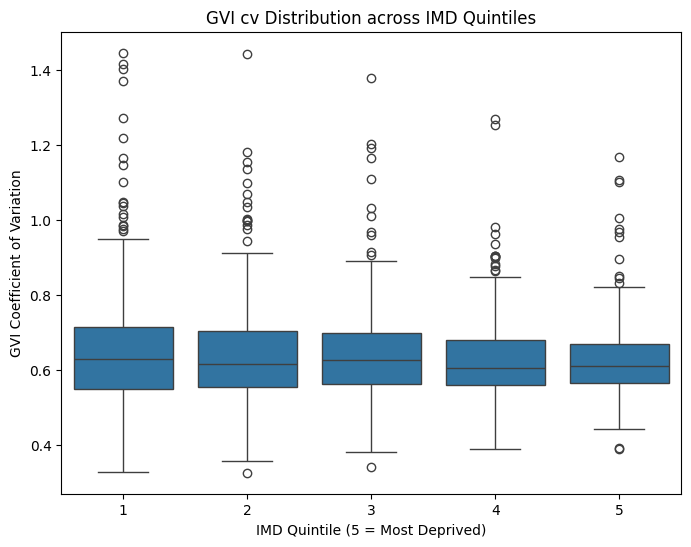

Kruskal-Wallis Hk = 3.295, p = 0.5097


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/2146870963.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group["green_cv_15min"].values for _, group in df.groupby("imd_quintile")]


In [9]:
# Ensure output directory exists
output_dir = "output/4/4.1.2"
os.makedirs(output_dir, exist_ok=True)

# Step 1.2.3 Boxplots + Kruskal–Wallis test + Dunn’s test

# Boxplot: visualize GVI distribution across socioeconomic groups
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="imd_quintile", y="green_cv_15min")
plt.xlabel("IMD Quintile (5 = Most Deprived)")
plt.ylabel("GVI Coefficient of Variation")
plt.title("GVI cv Distribution across IMD Quintiles")
# Save figure
plt.savefig(os.path.join(output_dir, "gvi_cv_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()

# Kruskal–Wallis test (non-parametric, multi-group differences)
groups = [group["green_cv_15min"].values for _, group in df.groupby("imd_quintile")]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis Hk = {stat:.3f}, p = {p:.4f}")

# If significant (p < 0.05), perform Dunn’s post hoc test
if p < 0.05:
    dunn_result = sp.posthoc_dunn(df, val_col="green_cv_15min", group_col="imd_quintile", p_adjust="bonferroni")
    print("\nDunn’s post hoc result (p-values):")
    print(dunn_result)

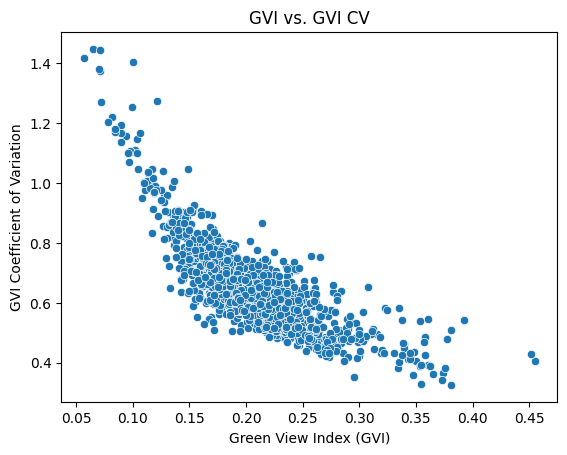

Pearson correlation:
                            green_mean_15min_weighted  green_cv_15min
green_mean_15min_weighted                   1.000000       -0.785449
green_cv_15min                             -0.785449        1.000000
Spearman correlation:
                            green_mean_15min_weighted  green_cv_15min
green_mean_15min_weighted                   1.000000       -0.797717
green_cv_15min                             -0.797717        1.000000


In [10]:
# Ensure output directory exists
output_dir = "output/4/4.1.3"
os.makedirs(output_dir, exist_ok=True)

# Example 2: GVI weighted mean vs. CV
sns.scatterplot(data=merged_df, x="green_mean_15min_weighted", y="green_cv_15min")
plt.xlabel("Green View Index (GVI)")       
plt.ylabel("GVI Coefficient of Variation")
plt.title("GVI vs. GVI CV")


plt.savefig(os.path.join(output_dir, "GVI_vs_CV.png"), dpi=300, bbox_inches="tight")
plt.show()

# Pearson linear correlation
corr_pearson = merged_df[["green_mean_15min_weighted", "green_cv_15min"]].corr(method="pearson")

# Spearman non-linear correlation (more robust)
corr_spearman = merged_df[["green_mean_15min_weighted", "green_cv_15min"]].corr(method="spearman")

print("Pearson correlation:\n", corr_pearson)
print("Spearman correlation:\n", corr_spearman)

## Step 2: Statistical Association Modeling

In [11]:
!pip install --upgrade statsmodels

In [12]:
import statsmodels.api as sm

# Step 2.2: OLS / WLS multivariate regression modeling

# Correlation analysis between overall IMD and GVI

# Independent and dependent variables
X = df[["imd_score"]]
X = sm.add_constant(X)
y = df["green_mean_15min_weighted"]

# Modeling
model = sm.OLS(y, X).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     green_mean_15min_weighted   R-squared:                       0.015
Model:                                   OLS   Adj. R-squared:                  0.015
Method:                        Least Squares   F-statistic:                     26.90
Date:                       Mon, 18 Aug 2025   Prob (F-statistic):           2.40e-07
Time:                               20:17:29   Log-Likelihood:                 2937.3
No. Observations:                       1737   AIC:                            -5871.
Df Residuals:                           1735   BIC:                            -5860.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [13]:
## Relationships between GVI and individual IMD subdomains

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Select variables
cols = [
    "income_score", "employment_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]

# Standardize variables (optional, for comparing standardized coefficients)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols])
X_scaled = pd.DataFrame(X_scaled, columns=cols)

# Add constant term
X_scaled = sm.add_constant(X_scaled)
y = df["green_mean_15min_weighted"]

# Build OLS model
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     green_mean_15min_weighted   R-squared:                       0.125
Model:                                   OLS   Adj. R-squared:                  0.122
Method:                        Least Squares   F-statistic:                     35.34
Date:                       Mon, 18 Aug 2025   Prob (F-statistic):           2.31e-46
Time:                               20:17:29   Log-Likelihood:                 3040.1
No. Observations:                       1737   AIC:                            -6064.
Df Residuals:                           1729   BIC:                            -6020.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [38]:
# New regression analysis (employment_score removed)

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select variables (employment_score removed)
cols_no_emp = [
    "income_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]

# Standardize variables (optional, for comparing standardized coefficients)
scaler = StandardScaler()
X_scaled_no_emp = scaler.fit_transform(df[cols_no_emp])
X_scaled_no_emp = pd.DataFrame(X_scaled_no_emp, columns=cols_no_emp)

# Add constant term
X_scaled_no_emp = sm.add_constant(X_scaled_no_emp)
y = df["green_mean_15min_weighted"]

# Build OLS model
model_no_emp = sm.OLS(y, X_scaled_no_emp).fit()
print(model_no_emp.summary())

                                OLS Regression Results                               
Dep. Variable:     green_mean_15min_weighted   R-squared:                       0.120
Model:                                   OLS   Adj. R-squared:                  0.117
Method:                        Least Squares   F-statistic:                     39.31
Date:                       Tue, 19 Aug 2025   Prob (F-statistic):           5.30e-45
Time:                               05:38:03   Log-Likelihood:                 3034.9
No. Observations:                       1737   AIC:                            -6056.
Df Residuals:                           1730   BIC:                            -6018.
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Ensure output directory exists
output_dir = "output/4/4.2"
os.makedirs(output_dir, exist_ok=True)

# Only include seven independent variables (without constant term)
X_vif = df[[
    "income_score", "employment_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]]

vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]


print(vif_df)


vif_path = os.path.join(output_dir, "vif_table.csv")
vif_df.to_csv(vif_path, index=False)

print(f"\n VIF table saved to: {vif_path}")

           Variable        VIF
0      income_score  62.141888
1  employment_score  48.529251
2         edu_score   6.091893
3      health_score   1.945472
4       crime_score   1.898767
5     barrier_score  15.059688
6         env_score   9.215105

 VIF table saved to: output/4/4.2/vif_table.csv


In [37]:
# New VIF analysis (employment_score removed)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Ensure output directory exists
output_dir = "output/4/4.2"
os.makedirs(output_dir, exist_ok=True)

# Only include seven independent variables (without constant term)
X_vif = df[[
    "income_score","edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]]

vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]


print(vif_df)


vif_path = os.path.join(output_dir, "vif_table.csv")
vif_df.to_csv(vif_path, index=False)


           Variable        VIF
0  employment_score  11.817353
1         edu_score   5.468955
2      health_score   1.880837
3       crime_score   1.883416
4     barrier_score  14.011707
5         env_score   9.214213


In [15]:
## Attempt Ridge Regression

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Prepare variables (standardization)
X = df[[
    "income_score", "employment_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]]
y = df["green_mean_15min_weighted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regression (cross-validation to select the optimal alpha)
alphas = np.logspace(-4, 4, 100)
ridge_model = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_scaled, y)

# Output coefficients
ridge_coefs = pd.Series(ridge_model.coef_, index=X.columns)
print(f"Best alpha: {ridge_model.alpha_}")
print(ridge_coefs.sort_values(key=abs, ascending=False))

Best alpha: 14.849682622544666
env_score          -0.015523
employment_score    0.009061
income_score       -0.008510
edu_score          -0.006187
health_score       -0.005119
crime_score         0.004026
barrier_score      -0.000553
dtype: float64


/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [40]:
# New Ridge Regression (employment_score removed)

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Prepare variables (employment_score removed)
X_no_emp = df[[
    "income_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]]
y = df["green_mean_15min_weighted"]

# Standardization
scaler = StandardScaler()
X_scaled_no_emp = scaler.fit_transform(X_no_emp)

# Ridge regression (cross-validation to select the optimal alpha)
alphas = np.logspace(-4, 4, 100)
ridge_model_no_emp = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_scaled_no_emp, y)

# Output coefficients
ridge_coefs_no_emp = pd.Series(ridge_model_no_emp.coef_, index=X_no_emp.columns)
print(f"Best alpha (no employment): {ridge_model_no_emp.alpha_}")
print(ridge_coefs_no_emp.sort_values(key=abs, ascending=False))

Best alpha (no employment): 45.34878508128591
env_score       -0.015269
edu_score       -0.005918
health_score    -0.004351
crime_score      0.003909
barrier_score   -0.000945
income_score    -0.000441
dtype: float64


/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [39]:
# # OLS regression coefficients (including intercept)
print(model.params)

const            0.204816
income_score    -0.000204
edu_score       -0.006321
health_score    -0.004651
crime_score      0.004177
barrier_score   -0.000867
env_score       -0.015805
dtype: float64


In [17]:
import statsmodels.api as sm

# Add constant term
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df = sm.add_constant(X_scaled_df)

# Weighting variable: the more samples, the smaller the error
weights = df["num_samples"]

# Weighting variable: the more samples, the smaller the error
wls_model = sm.WLS(y, X_scaled_df, weights=weights).fit()
print(wls_model.summary())

                                WLS Regression Results                               
Dep. Variable:     green_mean_15min_weighted   R-squared:                       0.139
Model:                                   WLS   Adj. R-squared:                  0.136
Method:                        Least Squares   F-statistic:                     39.94
Date:                       Mon, 18 Aug 2025   Prob (F-statistic):           2.57e-52
Time:                               20:17:29   Log-Likelihood:                 2995.1
No. Observations:                       1737   AIC:                            -5974.
Df Residuals:                           1729   BIC:                            -5930.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [41]:
# New Weighted Least Squares (WLS) regression (employment_score removed)

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1) Independent variables (employment_score removed)
cols_no_emp = [
    "income_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]

# 2) Dependent variable and weights
y = df["green_mean_15min_weighted"]
weights = df["num_samples"]  # More samples → smaller error, used as weights

# 3) Standardize independent variables
scaler = StandardScaler()
X_scaled_no_emp = scaler.fit_transform(df[cols_no_emp])
X_scaled_df_no_emp = pd.DataFrame(X_scaled_no_emp, columns=cols_no_emp)

# 4) Add constant term
X_scaled_df_no_emp = sm.add_constant(X_scaled_df_no_emp)

# 5) Fit WLS model
wls_model_no_emp = sm.WLS(y, X_scaled_df_no_emp, weights=weights).fit()
print(wls_model_no_emp.summary())


                                WLS Regression Results                               
Dep. Variable:     green_mean_15min_weighted   R-squared:                       0.138
Model:                                   WLS   Adj. R-squared:                  0.135
Method:                        Least Squares   F-statistic:                     46.13
Date:                       Tue, 19 Aug 2025   Prob (F-statistic):           1.29e-52
Time:                               15:04:27   Log-Likelihood:                 2993.8
No. Observations:                       1737   AIC:                            -5974.
Df Residuals:                           1730   BIC:                            -5935.
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

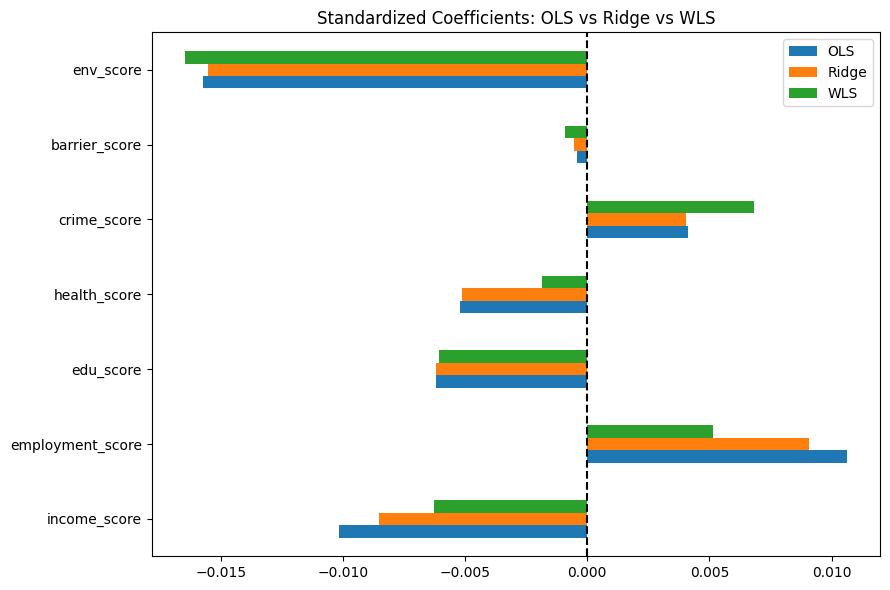

In [18]:
# Compare the results of three regression analyses
# Ensure output directory exists
output_dir = "output/4/4.2"
os.makedirs(output_dir, exist_ok=True)

import pandas as pd
import matplotlib.pyplot as plt

# Extract standardized coefficients from the three models (excluding the constant term)
ols_coefs = pd.Series(model.params[1:], index=cols)
ridge_coefs = pd.Series(ridge_model.coef_, index=cols)
wls_coefs = pd.Series(wls_model.params[1:], index=cols) 

# Combine into a DataFrame for comparison
coef_df = pd.DataFrame({
    "OLS": ols_coefs,
    "Ridge": ridge_coefs,
    "WLS": wls_coefs
})

# Visualization
coef_df.plot(kind="barh", figsize=(9, 6), title="Standardized Coefficients: OLS vs Ridge vs WLS")
plt.axvline(x=0, color="black", linestyle="--")
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(output_dir, "Standardized Coefficients: OLS vs Ridge vs WLS.png"), dpi=300, bbox_inches="tight")
plt.show()

Saved coefficients table to: output/4/4.2/standardized_coefs_ols_ridge_wls_no_employment.csv


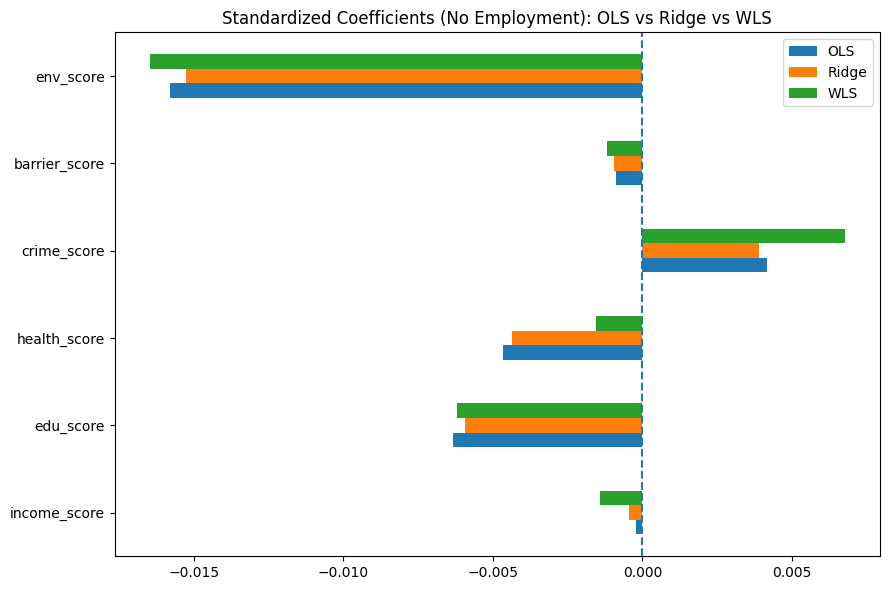

Saved figure to: output/4/4.2/standardized_coefs_ols_ridge_wls_no_employment.png


In [42]:
# Compare standardized coefficients of OLS, Ridge, and WLS (employment_score removed)

import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure output directory exists
output_dir = "output/4/4.2"
os.makedirs(output_dir, exist_ok=True)

# 1) Collect standardized coefficients (exclude constant terms for OLS/WLS)
ols_coefs_no_emp = pd.Series(model_no_emp.params, index=model_no_emp.params.index)
ols_coefs_no_emp = ols_coefs_no_emp.reindex(["const"] + cols_no_emp)[1:]  # drop constant, keep same order

wls_coefs_no_emp = pd.Series(wls_model_no_emp.params, index=wls_model_no_emp.params.index)
wls_coefs_no_emp = wls_coefs_no_emp.reindex(["const"] + cols_no_emp)[1:]  # drop constant, keep same order

ridge_coefs_no_emp = pd.Series(ridge_model_no_emp.coef_, index=cols_no_emp)

# 2) Combine into a DataFrame for comparison
coef_df_no_emp = pd.DataFrame({
    "OLS": ols_coefs_no_emp,
    "Ridge": ridge_coefs_no_emp,
    "WLS": wls_coefs_no_emp
})

# 3) (Optional) Save coefficients to CSV for paper tables
coef_csv_path = os.path.join(output_dir, "standardized_coefs_ols_ridge_wls_no_employment.csv")
coef_df_no_emp.to_csv(coef_csv_path)
print(f"Saved coefficients table to: {coef_csv_path}")

# 4) Visualization (horizontal bar chart)
ax = coef_df_no_emp.plot(
    kind="barh",
    figsize=(9, 6),
    title="Standardized Coefficients (No Employment): OLS vs Ridge vs WLS"
)
plt.axvline(x=0, linestyle="--")  # reference at zero
plt.tight_layout()

# 5) Save figure
fig_path = os.path.join(output_dir, "standardized_coefs_ols_ridge_wls_no_employment.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved figure to: {fig_path}")


In [19]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# ================== Output directory ==================
out_dir = "output/4/4.2"
os.makedirs(out_dir, exist_ok=True)

# Independent variables (subdomains)
cols = [
    "income_score", "employment_score", "edu_score", "health_score",
    "crime_score", "barrier_score", "env_score"
]
target = "green_mean_15min_weighted"

# Drop rows with missing values
used = df[cols + [target] + (["num_samples"] if "num_samples" in df.columns else [])].dropna().copy()

y = used[target].astype(float)
X = used[cols].astype(float)

# Standardize X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=cols, index=used.index)
X_scaled_const = sm.add_constant(X_scaled, has_constant="add")

# OLS
ols = sm.OLS(y, X_scaled_const).fit()

# WLS
weights = used["num_samples"].astype(float) if "num_samples" in used.columns else pd.Series(1.0, index=used.index)
wls = sm.WLS(y, X_scaled_const, weights=weights).fit()

# Ridge
alphas = np.logspace(-4, 4, 100)
ridge = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_scaled.values, y.values)

# Fully standardized coefficients (Appendix)
sigma_y = y.std(ddof=1)

# ================== Main Table (no SE, no standardized col) ==================
rows_main = []
for var in cols:
    rows_main.append({
        "Variable (Subdomain)": var,
        "OLS Coefficient": f"{ols.params[var]:.4f}",
        "p-value (OLS)": f"{ols.pvalues[var]:.4f}",
        "WLS Coefficient": f"{wls.params[var]:.4f}",
        "p-value (WLS)": f"{wls.pvalues[var]:.4f}",
        "Ridge Coefficient": f"{ridge.coef_[cols.index(var)]:.4f}",
    })

# Model stats
rows_main += [
    {"Variable (Subdomain)": "R² (OLS)", "OLS Coefficient": f"{ols.rsquared:.4f}",
     "p-value (OLS)": "—", "WLS Coefficient": "—", "p-value (WLS)": "—",
     "Ridge Coefficient": "—"},
    {"Variable (Subdomain)": "R² (WLS)", "OLS Coefficient": "—", "p-value (OLS)": "—",
     "WLS Coefficient": f"{wls.rsquared:.4f}", "p-value (WLS)": "—",
     "Ridge Coefficient": "—"},
    {"Variable (Subdomain)": "Sample Size (N)", "OLS Coefficient": f"{len(used)}",
     "p-value (OLS)": "—", "WLS Coefficient": "—", "p-value (WLS)": "—",
     "Ridge Coefficient": "—"}
]
table_main = pd.DataFrame(rows_main)

# ================== Appendix Table (with SE + fully standardized) ==================
def fmt_coef_se(coef, se):
    return f"{coef:.4f} ({se:.4f})"

rows_appendix = []
for var in cols:
    rows_appendix.append({
        "Variable (Subdomain)": var,
        "OLS Coefficient (SE)": fmt_coef_se(ols.params[var], ols.bse[var]),
        "p-value (OLS)": f"{ols.pvalues[var]:.4f}",
        "WLS Coefficient (SE)": fmt_coef_se(wls.params[var], wls.bse[var]),
        "p-value (WLS)": f"{wls.pvalues[var]:.4f}",
        "Ridge Coefficient": f"{ridge.coef_[cols.index(var)]:.4f}",
        "Fully Standardized Coefficient (OLS)": f"{ols.params[var] / sigma_y:.4f}"
    })

rows_appendix += [
    {"Variable (Subdomain)": "Intercept",
     "OLS Coefficient (SE)": fmt_coef_se(ols.params["const"], ols.bse["const"]),
     "p-value (OLS)": "—",
     "WLS Coefficient (SE)": fmt_coef_se(wls.params["const"], wls.bse["const"]),
     "p-value (WLS)": "—",
     "Ridge Coefficient": "—",
     "Fully Standardized Coefficient (OLS)": "—"},
    {"Variable (Subdomain)": "R² (OLS)", "OLS Coefficient (SE)": f"{ols.rsquared:.4f}",
     "p-value (OLS)": "—", "WLS Coefficient (SE)": "—", "p-value (WLS)": "—",
     "Ridge Coefficient": "—", "Fully Standardized Coefficient (OLS)": "—"},
    {"Variable (Subdomain)": "R² (WLS)", "OLS Coefficient (SE)": "—", "p-value (OLS)": "—",
     "WLS Coefficient (SE)": f"{wls.rsquared:.4f}", "p-value (WLS)": "—",
     "Ridge Coefficient": "—", "Fully Standardized Coefficient (OLS)": "—"},
    {"Variable (Subdomain)": "Sample Size (N)", "OLS Coefficient (SE)": f"{len(used)}",
     "p-value (OLS)": "—", "WLS Coefficient (SE)": "—", "p-value (WLS)": "—",
     "Ridge Coefficient": "—", "Fully Standardized Coefficient (OLS)": "—"}
]
table_appendix = pd.DataFrame(rows_appendix)

# ================== Save ==================
main_csv = os.path.join(out_dir, "regression_table_main.csv")
main_xlsx = os.path.join(out_dir, "regression_table_main.xlsx")
appendix_csv = os.path.join(out_dir, "regression_table_appendix.csv")
appendix_xlsx = os.path.join(out_dir, "regression_table_appendix.xlsx")

table_main.to_csv(main_csv, index=False)
table_main.to_excel(main_xlsx, index=False)
table_appendix.to_csv(appendix_csv, index=False)
table_appendix.to_excel(appendix_xlsx, index=False)

print(f"\n Saved Main Table to:\n- {main_csv}\n- {main_xlsx}")
print(f" Saved Appendix Table to:\n- {appendix_csv}\n- {appendix_xlsx}")



 Saved Main Table to:
- output/4/4.2/regression_table_main.csv
- output/4/4.2/regression_table_main.xlsx
 Saved Appendix Table to:
- output/4/4.2/regression_table_appendix.csv
- output/4/4.2/regression_table_appendix.xlsx


/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


## Step 3 Spatial Clustering Analysis (Local Moran’s I and Bivariate Moran’s I)

In [20]:
# === Read LSOA boundaries and convert to British National Grid coordinates ===
import geopandas as gpd
lsoa = gpd.read_file("data/ESRI/LSOA_2011_London_gen_MHW.shp").to_crs(epsg=27700)
inner_boroughs = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]

lsoa = lsoa[lsoa["LAD11NM"].isin(inner_boroughs)].copy()

In [21]:
import geopandas as gpd
import libpysal
import esda
from esda.moran import Moran_Local
from splot.esda import plot_local_autocorrelation
import matplotlib.pyplot as plt

# After merging attribute data, remove missing values (e.g., LSOAs without matched GVI)
lsoa_merged = lsoa.merge(df, left_on="LSOA11CD", right_on="lsoa_code", how="left")
print(lsoa_merged.columns.tolist())

['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry', 'lsoa_code', 'green_mean_15min_simple', 'green_mean_15min_weighted', 'green_std_15min', 'green_cv_15min', 'num_samples', 'imd_score', 'imd_rank', 'imd_decile', 'income_score', 'employment_score', 'edu_score', 'health_score', 'crime_score', 'barrier_score', 'env_score', 'imd_quintile']


In [22]:
lsoa_clean = lsoa_merged.dropna(subset=["green_mean_15min_weighted", "imd_score"]).copy()

In [23]:
lsoa_clean.head()

LSOA11CD             LSOA11NM   MSOA11CD            MSOA11NM    LAD11CD  \
0  E01000001  City of London 001A  E02000001  City of London 001  E09000001   
1  E01000002  City of London 001B  E02000001  City of London 001  E09000001   
2  E01000003  City of London 001C  E02000001  City of London 001  E09000001   
3  E01000005  City of London 001E  E02000001  City of London 001  E09000001   
4  E01000842          Camden 011A  E02000176          Camden 011  E09000007   

          LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  ...  imd_rank  \
0  City of London  E12000007  London      1465      1465  ...     29199   
1  City of London  E12000007  London      1436      1436  ...     30379   
2  City of London  E12000007  London      1346      1250  ...     14915   
3  City of London  E12000007  London       985       985  ...      8678   
4          Camden  E12000007  London      1444      1368  ...     26391   

   imd_decile  income_score  employment_score edu_score health_score  \
0           9         0.007             0.010     0.024       -1.654   
1          10         0.034             0.027     0.063       -1.115   
2           5         0.086             0.086     5.804       -0.102   
3           3         0.211             0.136    22.260       -0.121   
4           9         0.052             0.043     5.409       -1.457   

   crime_score  barrier_score  env_score  imd_quintile  
0       -2.012         29.472     31.873             1  
1       -2.343         24.412     23.084             1  
2       -1.032         40.103     40.535             2  
3       -1.317         39.900     28.979             4  
4        0.000         20.650     28.562             1  

[5 rows x 32 columns]

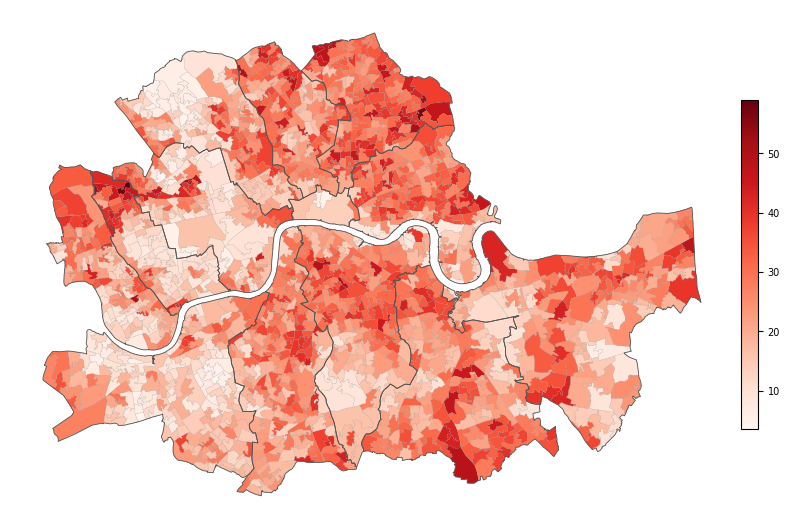

Saved：output/3/imd_map.png


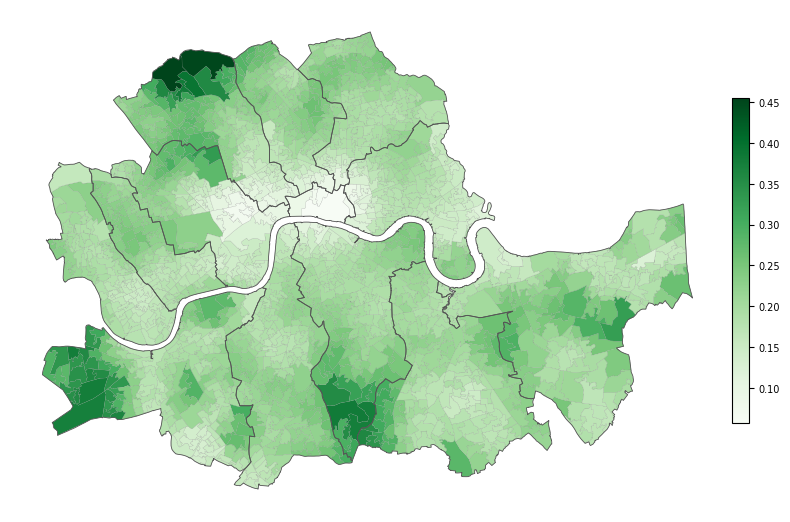

Saved：output/3/gvi_map.png


In [24]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors

# Read and filter 
gdf = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")
inner_borough_names = [
    "Camden","Islington","Hackney","Tower Hamlets","Westminster",
    "Kensington and Chelsea","Hammersmith and Fulham","Lambeth",
    "Southwark","Wandsworth","Lewisham","Greenwich","City of London"
]
inner_london = gdf[gdf["NAME"].isin(inner_borough_names)]

# Style  
BORO_EDGE_COLOR = "#555555"     # 内伦敦各 borough 分界（深灰）
BORO_EDGE_WIDTH = 0.6


os.makedirs("output/3", exist_ok=True)

# Figure 1: IMD
fig, ax = plt.subplots(figsize=(8, 6))

lsoa_clean.plot(
    column="imd_score",
    cmap="Reds",
    linewidth=0.1,
    edgecolor="grey",
    legend=False,
    ax=ax
)

# Overlay: Inner London borough boundaries
inner_london.boundary.plot(ax=ax, color=BORO_EDGE_COLOR, linewidth=BORO_EDGE_WIDTH)

# Short colorbar
sm1 = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=colors.Normalize(vmin=lsoa_clean["imd_score"].min(),
                          vmax=lsoa_clean["imd_score"].max())
)
cbar1 = fig.colorbar(sm1, ax=ax, fraction=0.022, pad=0.01)
cbar1.ax.tick_params(labelsize=7)

ax.axis("off")
plt.tight_layout()
out1 = "output/3/imd_map.png"
plt.savefig(out1, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved：{out1}")

# Figure 2: GVI 
fig, ax = plt.subplots(figsize=(8, 6))

lsoa_clean.plot(
    column="green_mean_15min_weighted",
    cmap="Greens",
    linewidth=0.1,
    edgecolor="grey",
    legend=False,
    ax=ax
)

inner_london.boundary.plot(ax=ax, color=BORO_EDGE_COLOR, linewidth=BORO_EDGE_WIDTH)

sm2 = plt.cm.ScalarMappable(
    cmap="Greens",
    norm=colors.Normalize(vmin=lsoa_clean["green_mean_15min_weighted"].min(),
                          vmax=lsoa_clean["green_mean_15min_weighted"].max())
)
cbar2 = fig.colorbar(sm2, ax=ax, fraction=0.022, pad=0.01)
cbar2.ax.tick_params(labelsize=7)

ax.axis("off")
plt.tight_layout()
out2 = "output/3/gvi_map.png"
plt.savefig(out2, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved：{out2}")


In [29]:
from libpysal.weights import KNN
w = KNN.from_dataframe(lsoa_clean, k=5)
w.transform = 'r'  # row-standardized

# Check if there are any isolated units
islands = [i for i, n in w.neighbors.items() if len(n) == 0]
print(f"Number of islands (no neighbors): {len(islands)}")

Number of islands (no neighbors): 0


In [26]:
## Generate an outer outline

boroughs = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")

inner_names = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]

inner_outline = boroughs[boroughs["NAME"].isin(inner_names)].dissolve()

inner_outline_gdf = gpd.GeoDataFrame(geometry=inner_outline.geometry, crs=boroughs.crs)


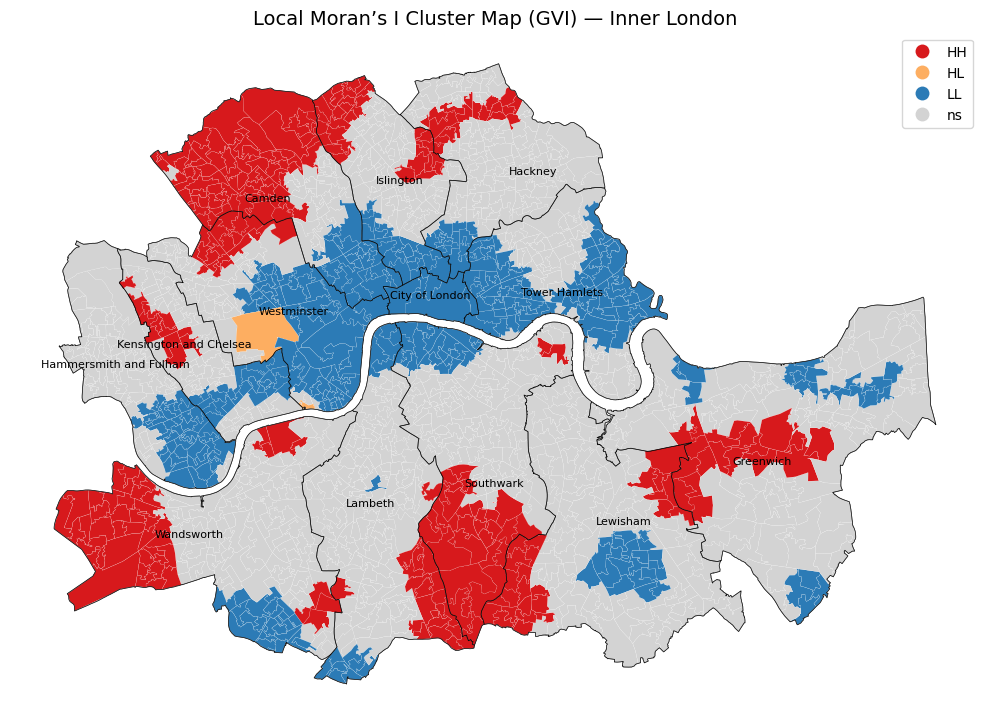

 Figure saved to: output/4/4.3/lisa_cluster_gvi_inner_london.png


In [27]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from libpysal.weights import KNN

# ============== Paths & Output ==============
out_dir = "output/4/4.3"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "lisa_cluster_gvi_inner_london.png")

# ============== Read Data ==============
boroughs = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")
# Assume you already have lsoa_clean
# lsoa_clean = gpd.read_file("path/to/lsoa_clean.geojson")

# ============== Inner London List & Outer Boundary ==============
inner_names = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]
inner_outline = boroughs[boroughs["NAME"].isin(inner_names)].dissolve()
inner_outline_gdf = gpd.GeoDataFrame(geometry=inner_outline.geometry, crs=boroughs.crs)

# ============== Align CRS ==============
if boroughs.crs != lsoa_clean.crs:
    boroughs = boroughs.to_crs(lsoa_clean.crs)
if inner_outline_gdf.crs != lsoa_clean.crs:
    inner_outline_gdf = inner_outline_gdf.to_crs(lsoa_clean.crs)

# ============== Add Borough Name to LSOA (if not already present) ==============
if "borough_name" not in lsoa_clean.columns:
    lsoa_with_b = gpd.sjoin(lsoa_clean, boroughs[["NAME", "geometry"]], how="left", predicate="intersects")
    lsoa_with_b = lsoa_with_b.rename(columns={"NAME": "borough_name"})
else:
    lsoa_with_b = lsoa_clean.copy()

# Keep only Inner London LSOAs
inner_lsoa = lsoa_with_b[lsoa_with_b["borough_name"].isin(inner_names)].copy()

# ============== Variable & Weights (Inner London only) ==============
y = inner_lsoa["green_mean_15min_weighted"].astype(float)
centroids = inner_lsoa.geometry.centroid
coords = np.column_stack([centroids.x.values, centroids.y.values])
w = KNN.from_array(coords, k=8)
w.transform = "R"

# ============== Local Moran's I ==============
moran_loc = Moran_Local(y, w)
inner_lsoa["LISA_cluster"] = moran_loc.q
inner_lsoa["LISA_significant"] = moran_loc.p_sim < 0.05

# ============== Plot (Inner London only) ==============
fig, ax = plt.subplots(figsize=(10, 8))

# 1) LISA cluster map
lisa_cluster(moran_loc, inner_lsoa, p=0.05, ax=ax)
ax.set_title("Local Moran’s I Cluster Map (GVI) — Inner London", fontsize=14)

# 2) Outer boundary of Inner London (dark gray, slightly thicker)
inner_outline_gdf.boundary.plot(ax=ax, color="dimgray", linewidth=0.5, zorder=5)

# 3) Inner London borough boundaries (dark gray)
inner_boroughs = boroughs[boroughs["NAME"].isin(inner_names)]
inner_boroughs.boundary.plot(ax=ax, color="black", linewidth=0.5, alpha=0.8, zorder=6)

# 4) Borough name labels (black, no outline)
for _, row in inner_boroughs.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    pt = row.geometry.representative_point()
    ax.text(
        pt.x, pt.y, row["NAME"],
        fontsize=8, color="black", ha="center", va="center", zorder=7
    )

# 5) Beautify & Export
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f" Figure saved to: {out_path}")


In [ ]:
from libpysal.weights import KNN
w = KNN.from_dataframe(lsoa_clean, k=5)
w.transform = 'r'  # row-standardized

# Check if there are any isolated units
islands = [i for i, n in w.neighbors.items() if len(n) == 0]
print(f"Number of islands (no neighbors): {len(islands)}")

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/816658721.py:57: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


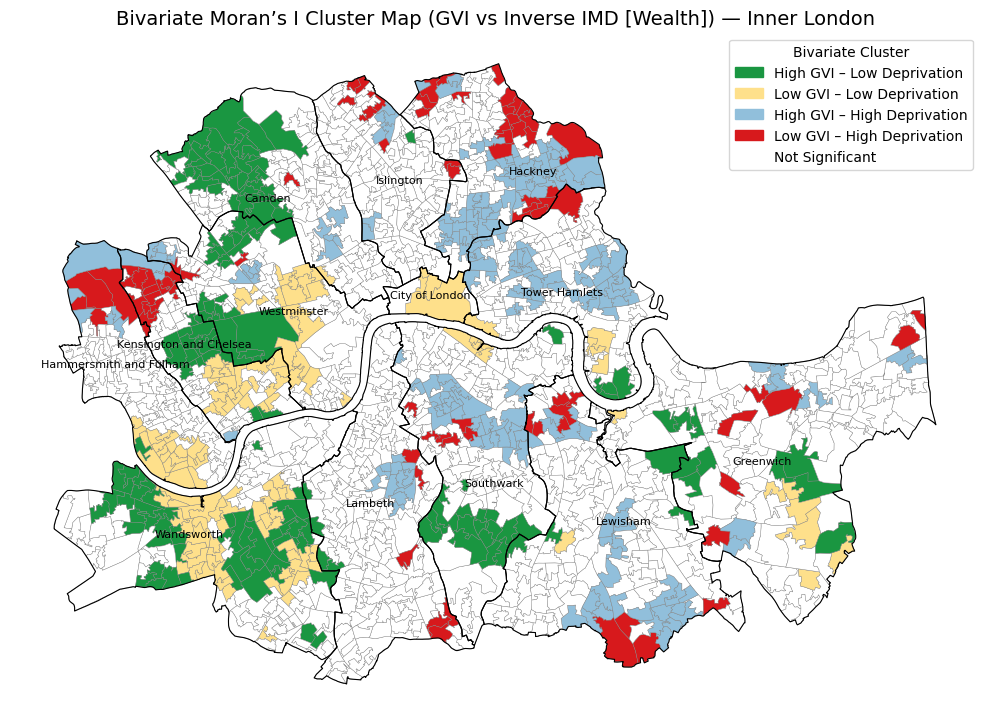

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from esda.moran import Moran_Local_BV
from libpysal.weights import Queen

# ===== Data and weights calculation =====
lsoa_clean["imd_inverse"] = -lsoa_clean["imd_score"]
y1 = lsoa_clean["green_mean_15min_weighted"]
y2 = lsoa_clean["imd_inverse"]

moran_bv = Moran_Local_BV(y1, y2, w)
lsoa_clean["Bi_Cluster"] = moran_bv.q
lsoa_clean["Bi_signif"] = moran_bv.p_sim < 0.05

cluster_colors = {
    1: "#1a9641",  # High GVI – Low Deprivation
    2: "#fee08b",  # Low GVI – Low Deprivation
    3: "#91bfdb",  # High GVI – High Deprivation
    4: "#d7191c"   # Low GVI – High Deprivation
}
lsoa_clean["color"] = lsoa_clean.apply(
    lambda row: cluster_colors[row["Bi_Cluster"]] if row["Bi_signif"] else "#ffffff", axis=1
)

# ===== Inner London borough boundaries and labels =====
boroughs = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")
inner_names = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]
inner_boroughs = boroughs[boroughs["NAME"].isin(inner_names)]

# Align CRS
if inner_boroughs.crs != lsoa_clean.crs:
    inner_boroughs = inner_boroughs.to_crs(lsoa_clean.crs)

# ===== Plot =====
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
lsoa_clean.plot(color=lsoa_clean["color"], ax=ax, edgecolor='grey', linewidth=0.3)

inner_boroughs.boundary.plot(ax=ax, color="black", linewidth=0.8, zorder=5)

for _, row in inner_boroughs.iterrows():
    pt = row.geometry.representative_point()
    ax.text(
        pt.x, pt.y, row["NAME"],
        fontsize=8, color="black", ha="center", va="center", zorder=6
    )

legend_elements = [
    mpatches.Patch(color="#1a9641", label="High GVI – Low Deprivation"),
    mpatches.Patch(color="#fee08b", label="Low GVI – Low Deprivation"),
    mpatches.Patch(color="#91bfdb", label="High GVI – High Deprivation"),
    mpatches.Patch(color="#d7191c", label="Low GVI – High Deprivation"),
    mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)
]
ax.legend(
    handles=legend_elements,
    loc='upper right',        # upper right corner
    title="Bivariate Cluster",
    frameon=True
)

ax.set_title("Bivariate Moran’s I Cluster Map (GVI vs Inverse IMD [Wealth]) — Inner London", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# Create output directory
out_dir = "outputs/4.3"
os.makedirs(out_dir, exist_ok=True)

# Save figure
out_path = os.path.join(out_dir, "bivariate_moran_inner_london.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_env_score_deprivation_inner.png


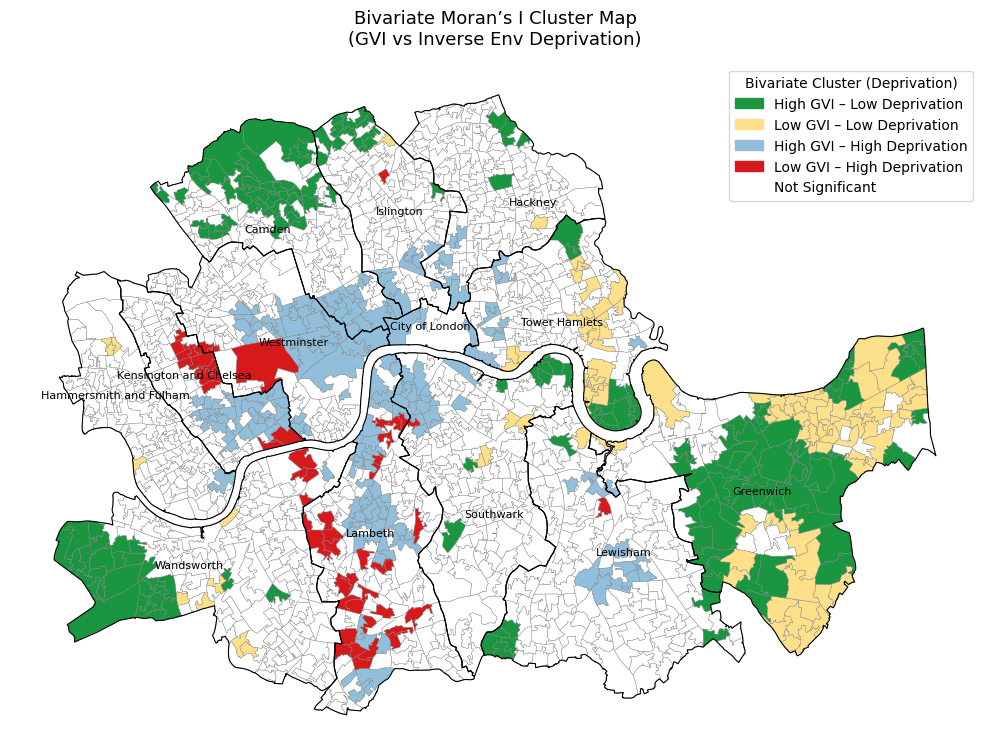

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_edu_score_deprivation_inner.png


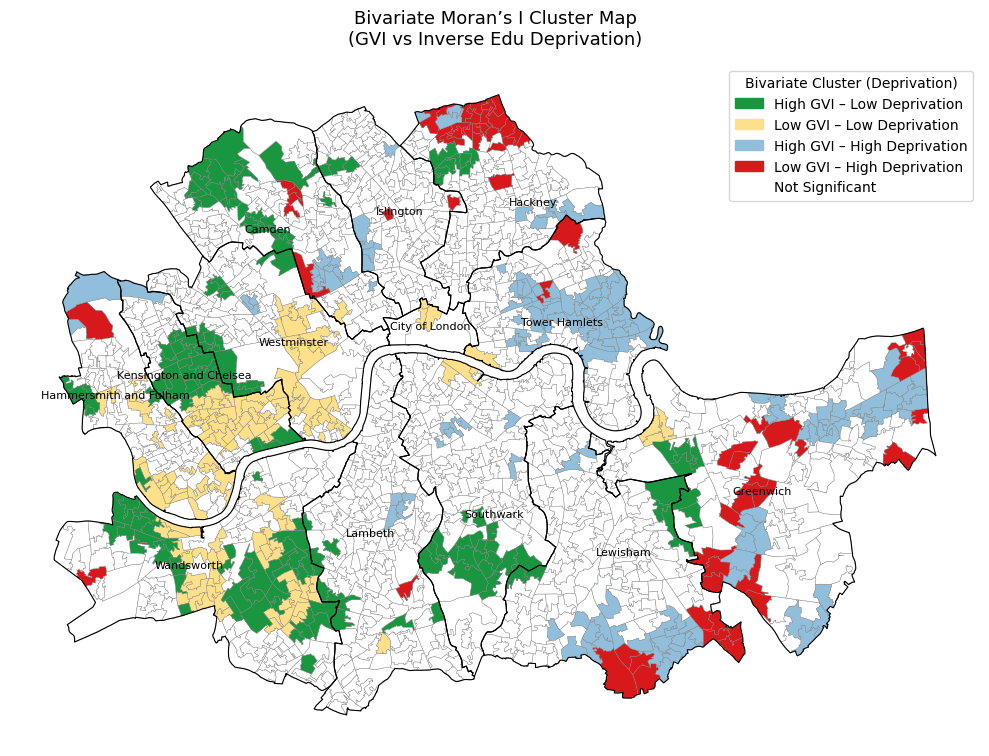

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_income_score_deprivation_inner.png


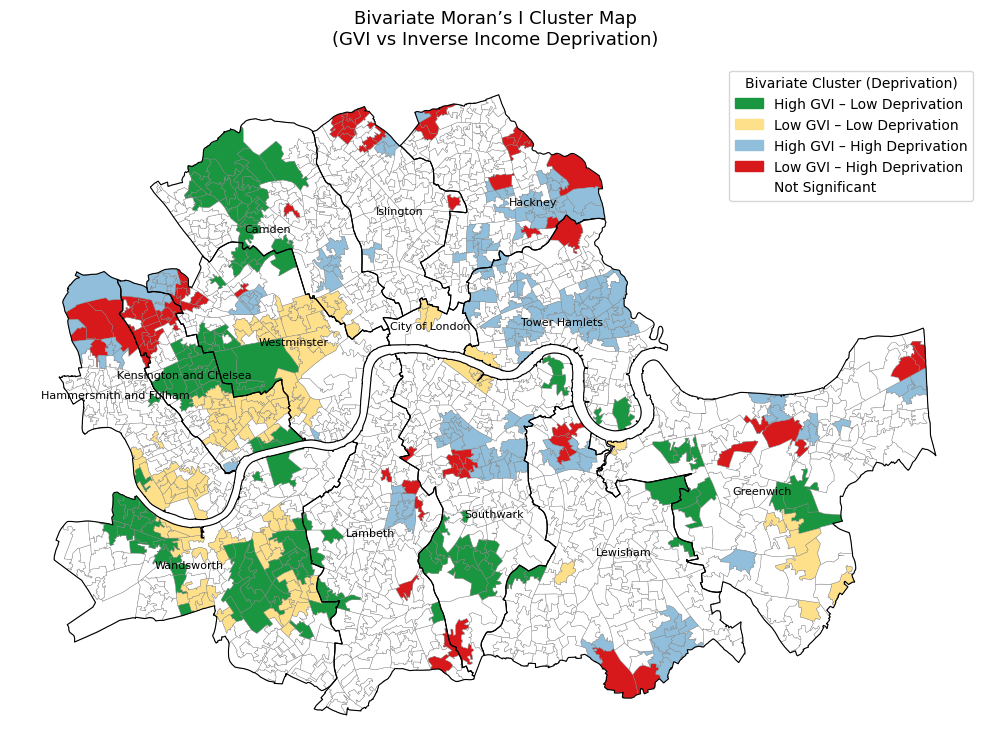

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_employment_score_deprivation_inner.png


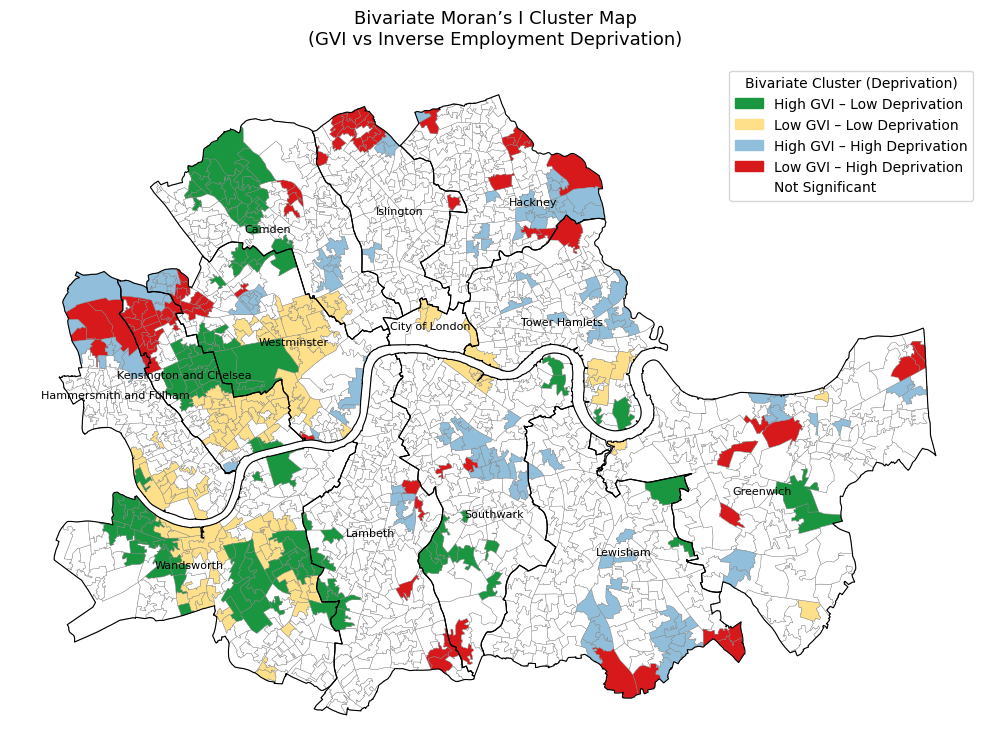

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_crime_score_deprivation_inner.png


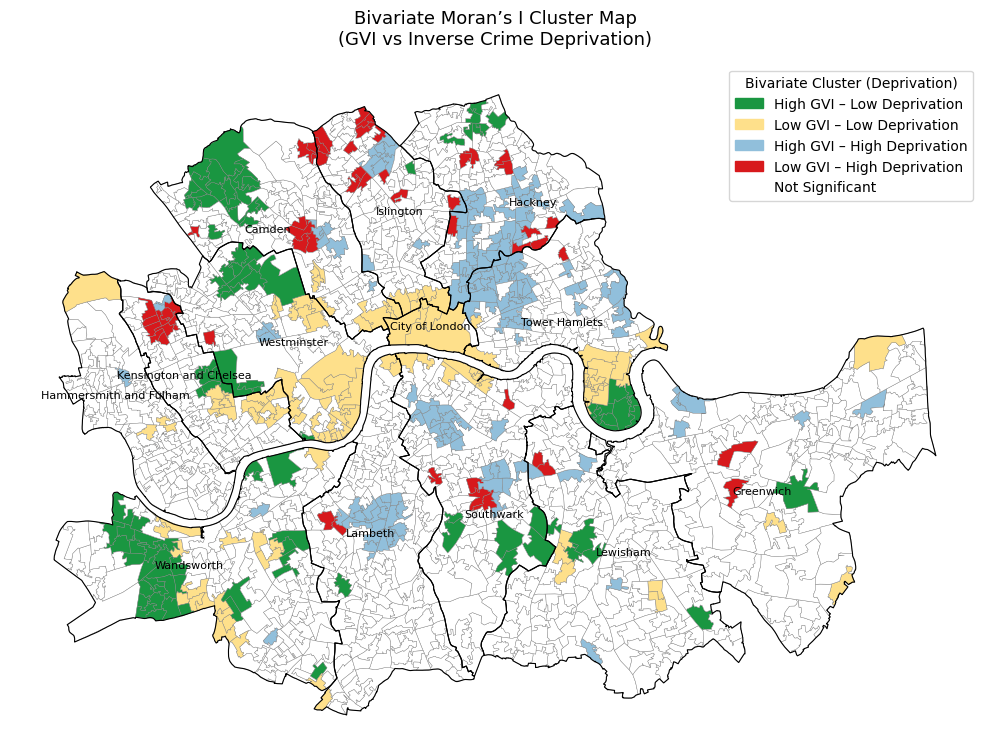

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_health_score_deprivation_inner.png


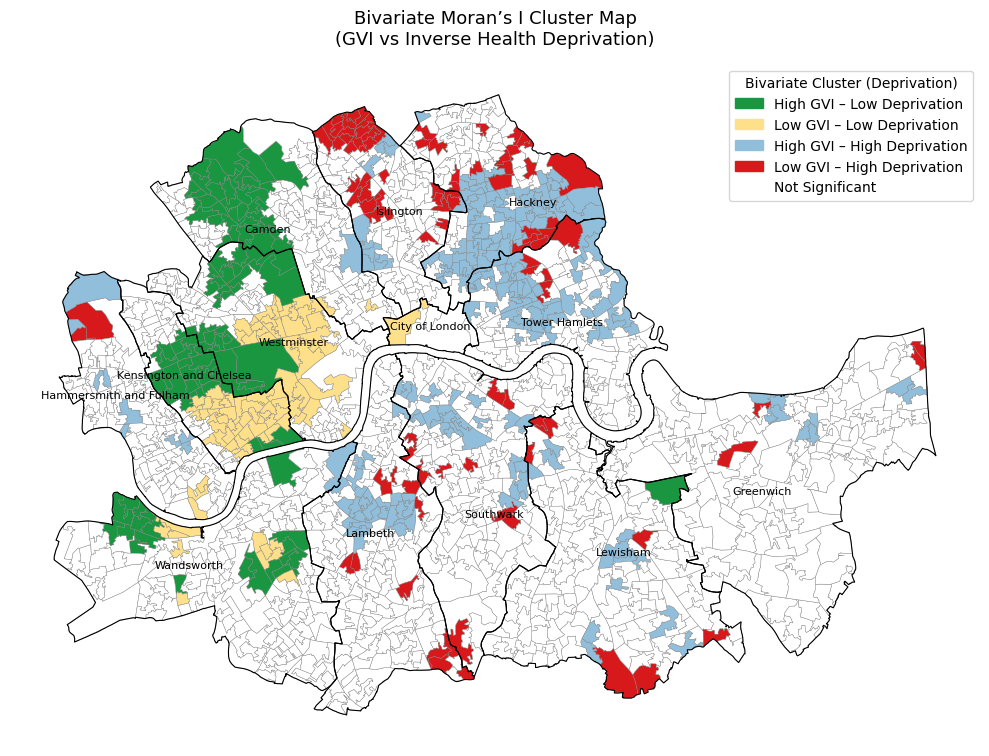

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_56198/1463756502.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)


 Saved: outputs/Picture/bivariate_moran_barrier_score_deprivation_inner.png


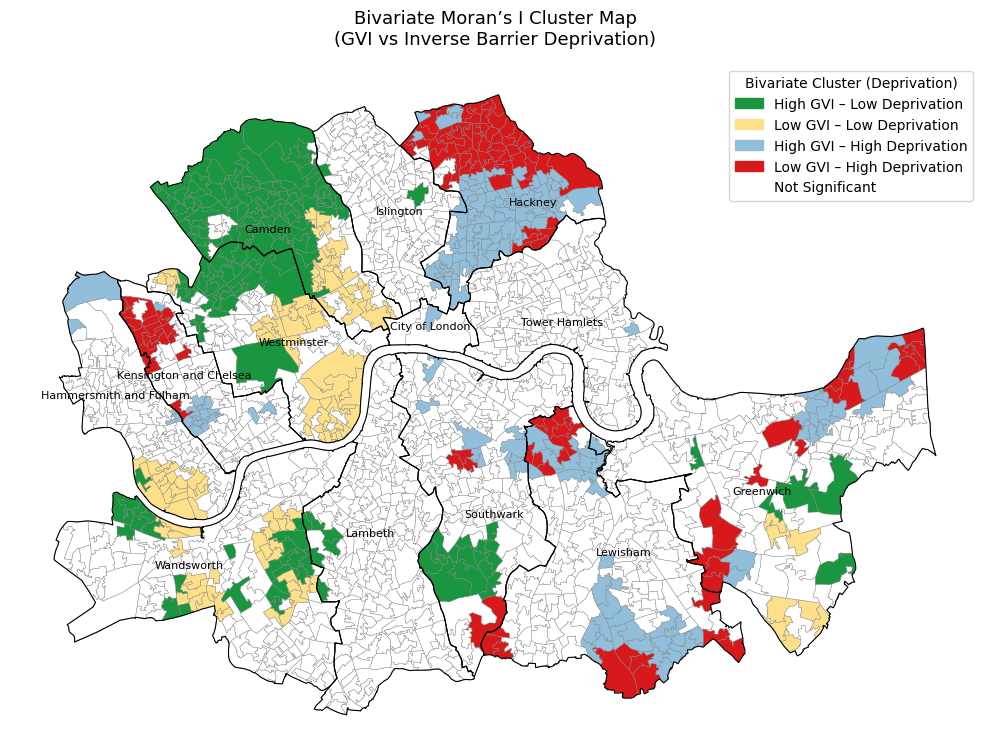

In [31]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from esda.moran import Moran_Local_BV

# Output directory
output_dir = "outputs/Picture"
os.makedirs(output_dir, exist_ok=True)

# IMD subdomains
subdomains = [
    "env_score", "edu_score", "income_score",
    "employment_score", "crime_score", "health_score", "barrier_score"
]

# Color mapping
cluster_colors = {
    1: "#1a9641",  # High GVI – Low Deprivation
    2: "#fee08b",  # Low GVI – Low Deprivation
    3: "#91bfdb",  # High GVI – High Deprivation
    4: "#d7191c"   # Low GVI – High Deprivation
}

# Inner London boundary data
boroughs = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")
inner_names = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]
inner_boroughs = boroughs[boroughs["NAME"].isin(inner_names)]

# Align CRS
if inner_boroughs.crs != lsoa_clean.crs:
    inner_boroughs = inner_boroughs.to_crs(lsoa_clean.crs)

for var in subdomains:
    # Data preparation
    y1 = lsoa_clean["green_mean_15min_weighted"]
    y2 = -lsoa_clean[var]  # inverse IMD score

    moran_bv = Moran_Local_BV(y1, y2, w)

    cl_col = f"Bi_Cluster_{var}"
    sg_col = f"Bi_signif_{var}"
    color_col = f"color_{var}"

    lsoa_clean[cl_col] = moran_bv.q
    lsoa_clean[sg_col] = moran_bv.p_sim < 0.05
    lsoa_clean[color_col] = lsoa_clean.apply(
        lambda r: cluster_colors[r[cl_col]] if r[sg_col] else "#ffffff",
        axis=1
    )

    # Plot (same style as for the overall IMD index)
    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    lsoa_clean.plot(color=lsoa_clean[color_col], ax=ax, edgecolor='grey', linewidth=0.3)

    # Inner London boundaries
    inner_boroughs.boundary.plot(ax=ax, color="black", linewidth=0.8, zorder=5)

    # Borough names
    for _, row in inner_boroughs.iterrows():
        pt = row.geometry.representative_point()
        ax.text(
            pt.x, pt.y, row["NAME"],
            fontsize=8, color="black", ha="center", va="center", zorder=6
        )

    # Legend (placed inside the map, upper-right corner)
    legend_elements = [
        mpatches.Patch(color="#1a9641", label="High GVI – Low Deprivation"),
        mpatches.Patch(color="#fee08b", label="Low GVI – Low Deprivation"),
        mpatches.Patch(color="#91bfdb", label="High GVI – High Deprivation"),
        mpatches.Patch(color="#d7191c", label="Low GVI – High Deprivation"),
        mpatches.Patch(color="#ffffff", label="Not Significant", edgecolor='black', linewidth=0.5)
    ]
    ax.legend(
        handles=legend_elements,
        title="Bivariate Cluster (Deprivation)",
        loc="upper right",
        frameon=True
    )

    # Title
    pretty = var.replace("_score", "").capitalize()
    ax.set_title(
        f"Bivariate Moran’s I Cluster Map\n(GVI vs Inverse {pretty} Deprivation)",
        fontsize=13, pad=14
    )
    ax.set_axis_off()
    plt.tight_layout()

    # Save figure
    outname = f"bivariate_moran_{var}_deprivation_inner.png"
    output_path = os.path.join(output_dir, outname)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f" Saved: {output_path}")

    plt.show()
